In [1]:
import sys
import polars as pl
import glob
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# adding Folder_2 to the system path
sys.path.insert(0, 'Python')
from helper_add_ep_wp import add_ep_variables, add_wp_variables
from helper_add_model_mutations import make_ep_model_mutations, make_wp_model_mutations
from helper_add_hudl_mutations import make_hudl_mutations, make_dsfootball_mutations, prepare_ep_data, prepare_wp_data

In [26]:
df = pl.read_csv("data_raw.csv",separator=";",infer_schema_length=0)
# rabbits = pl.read_csv("Z:/GitHub/rabbits_stats/outputs/pbp/pbp_data_*.csv",separator=";")
queries = []
for file in glob.glob("Z:/GitHub/rabbits_stats/outputs/pbp/pbp_data_*.csv"):
    q = pl.scan_csv(file,separator=";",infer_schema_length=0)
    queries.append(q)

rabbits = pl.concat(queries,how="diagonal").collect()

In [27]:
df = make_hudl_mutations(df)
df = df.with_columns(pl.col(pl.UInt32).cast(pl.Int32).name.keep())

In [33]:
df_wc.head(1)

index,season,competition_id,competition_name,competition_league,gender,game_id,game_type,game_group_id,game_group,half,summary,action_title,down,down_desc,down_after,down_after_desc,yards_to_go,yards_to_go_after,possession_time,home_team,away_team,home_score,away_score,stream_url,passer,receiver,rusher,tackle_player,interception_player,sack_player,play_result,penalty,safety,drive_id,play_id,half_end,play_type,complete_pass,interception,touchdown,point_after,point_after_success,def_touchdown,one_point_conv_success,two_point_conv_success,defensive_two_point_conv,scoring_play,posteam,defteam,posteam_after,defteam_after,yardline_50,yardline_50_after,yards_gained,yards_to_go_simple,first_down,scoring_play_team,home_team_points,away_team_points,home_team_score,away_team_score,posteam_score,defteam_score,score_differential
i32,i32,i32,str,str,i32,i32,str,i32,str,i32,str,str,i32,str,i32,str,i32,i32,str,str,str,i32,i32,str,i32,i32,i32,i32,i32,i32,str,str,i32,i32,i32,i32,str,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,str,str,str,str,i32,i32,i32,i32,i32,str,i32,i32,i32,i32,i32,i32,i32
1,2024,2,"""FlagWC""","""World cup""",2,956,"""Group stage""",47,"""Group B""",1,"""#33 Diana Flores Deep middle p…","""Pass incomplete""",1,"""1st""",2,"""2nd""",20,20,"""-6:-15""","""13""","""11""",6,45,"""https://ifaf.tv/sportitemset/6…",null,null,null,null,null,null,"""incomplete""",null,0,1,1,0,"""pass""",0,0,0,0,0,0,0,0,0,0,"""11""","""13""","""11""","""13""",5,5,0,4,0,null,0,0,0,0,0,0,0


In [18]:
df.head(1)

index,PLAY #,ODK,OFF FORM,Off Str,OFF PLAY,DN,DIST,YARD LN,RESULT,Drive Success,TARGET ROUTE,RECEIVED BY,GN/LS,Thrown By,YAC,QB,C,X/H,Y/CAT,Z,Target,Drop,B,yardline_50,game_id,play_id,drive_id,half,posteam,home_team,away_team,defteam,down,yards_to_go,yardline,yardline_50_simple,yards_to_go_simple,yardline_50_after,posteam_after,play_type,sack,interception,complete_pass,touchdown,def_touchdown,penalty,safety,one_point_conv_success,two_point_conv_success,defensive_two_point_conv,scoring_play,scoring_play_team,home_team_points,away_team_points,home_team_score,away_team_score,posteam_score,defteam_score,score_differential,yards_gained,first_down
u32,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i32,i32,i32,i32,i32,str,str,str,str,i32,i32,i32,i32,i32,i32,str,str,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,str,i32,i32,i32,i32,i32,i32,i32,i32,i32
1,"""1""","""Slot Left""","""Slot""","""Left""","""Dagger""","""1""","""20""","""-5""","""Complete""","""0""","""FADE""","""RIESS""","""32""","""THIELE""","""0""",null,null,null,null,null,"""RIESS""",null,null,5,1,1,1,1,"""GER""","""GER""","""OPP""","""OPP""",1,20,-5,0,4,37,"""GER""","""pass""",0,0,1,0,0,0,0,0,0,0,0,null,0,0,0,0,0,0,0,32,1


In [35]:
df_wc = (pl.read_csv("data/wc24_pbp.csv",separator=",",
                     schema_overrides = {"posteam": pl.String,"posteam_after": pl.String,"defteam": pl.String,"defteam_after": pl.String,
                                         "home_team": pl.String,"home_team_after": pl.String,"away_team": pl.String,"away_team_after": pl.String,
                                         "scoring_play_team": pl.String,"penalty": pl.Int32})
         .with_columns(pl.col(pl.Int64).cast(pl.Int32).name.keep())
         )

df = pl.concat([df, df_wc],how="diagonal")

In [36]:
df1 = prepare_wp_data(df)
df2 = prepare_ep_data(df1)

In [37]:
df2.shape

(18246, 106)

In [13]:
features_ep = [
    # "half_seconds_remaining",
    # "yardline_50",
    "yardline_50_simple",
    # "yards_to_go",
    "yards_to_go_simple",
    "down0", "down1", "down2", "down3", "down4",
    ]

features_wp = [
    "receive_2h_ko",
    "half_seconds_remaining",
    "game_seconds_remaining",
    "Diff_Time_Ratio",
    "score_differential",
    "down",
    # "yards_to_go",
    "yards_to_go_simple",
    # "yardline_50"
    "yardline_50_simple"
    ]

In [14]:
spain_data = df2.filter(pl.col("game_id") == 35)
spain_epa = make_ep_model_mutations(spain_data, features_ep).drop("label")
spain_wpa = make_wp_model_mutations(spain_data, features_wp).drop("label")

# spain_epa = make_ep_model_mutations(df2, features_ep).drop("label")

In [15]:
import pickle

# load model
# xgb_model_ep_loaded = pickle.load(open("models/ep_model.pkl", "rb"))
xgb_model_ep_loaded = pickle.load(open("models/ep_model_simple.pkl", "rb"))

pred_spain = xgb_model_ep_loaded.predict(spain_epa.to_numpy())

# Die Labels entsprechend deiner Definition
labels = ["Touchdown_Prob", 
          "Opp_Touchdown_Prob", 
        #   "Extra_Point_Prob", 
        #   "Two_Point_Conversion_Prob",
        #   "Opp_Two_Point_Conversion_Prob", 
          "Safety_Prob", 
          "Opp_Safety_Prob", 
          "No_Score_Prob"]

pred_spain = np.array(pred_spain)

# NumPy-Array in ein Pandas DataFrame umwandeln
probs_spain = pd.DataFrame(pred_spain, columns=labels)

# probs_spain

probs_spain = pl.from_pandas(probs_spain)

spain_epa_raw = spain_data.hstack(probs_spain)

spain_epa = add_ep_variables(spain_epa_raw)

In [16]:
spain_epa.head(5)

index,PLAY #,ODK,OFF FORM,Off Str,OFF PLAY,DN,DIST,YARD LN,RESULT,Drive Success,TARGET ROUTE,RECEIVED BY,GN/LS,Thrown By,YAC,QB,C,X/H,Y/CAT,Z,Target,Drop,B,yardline_50,game_id,play_id,drive_id,half,posteam,home_team,away_team,defteam,down,yards_to_go,yardline,yardline_50_simple,…,posteam_score,defteam_score,score_differential,yards_gained,first_down,half_end,game_end,helper_one,play_id_half,play_time,half_seconds_remaining,game_seconds_remaining,elapsed_share,Diff_Time_Ratio,start_posteam,receive_2h_ko,scoring_event,score_drive,Next_Score_Half,Drive_Score_Half,max_play_id,Touchdown_Prob,Opp_Touchdown_Prob,Safety_Prob,Opp_Safety_Prob,No_Score_Prob,ExpPts,ep,tmp_posteam,home_ep,home_ep_after,home_epa,epa,home_team_epa,away_team_epa,total_home_epa,total_away_epa
u32,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i32,i32,i32,i32,i32,str,str,str,str,i32,i32,i32,i32,…,i32,i32,i32,i32,i32,i32,i32,i32,i32,f64,f64,f64,f64,f64,str,i32,str,i32,str,i32,i32,f32,f32,f32,f32,f32,f32,f32,str,f32,f32,f32,f64,f64,f64,f64,f64
2647,"""Spain""","""Germany""","""SPREAD""","""NO""",null,"""1""","""20""","""-5""","""Complete""","""1""","""FADE""",null,"""26""","""23""",null,null,null,null,null,null,null,null,null,5,35,1,1,1,"""ESP""","""ESP""","""GER""","""GER""",1,20,-5,0,…,0,0,0,26,1,0,0,1,1,0.0,1200.0,2400.0,0.0,0.0,"""ESP""",0,"""Touchdown""",1,"""Touchdown""",1,41,0.568393,0.250409,0.003678,0.007897,0.169623,1.899465,1.899465,"""ESP""",1.899465,3.977067,2.077602,2.077602,2.077602,-2.077602,2.077602,-2.077602
2648,"""Spain""","""Germany""","""SPREAD""","""NO""",null,"""1""","""19""","""19""","""Complete, TD""","""1""","""FADE""",null,"""19""","""28""",null,null,null,null,null,null,null,null,null,31,35,2,1,1,"""ESP""","""ESP""","""GER""","""GER""",1,19,19,1,…,6,0,6,14,0,0,0,1,2,29.268293,1170.731707,2370.731707,0.012195,6.299939,"""ESP""",1,"""Touchdown""",1,"""Touchdown""",1,41,0.777371,0.114883,0.00283,0.001762,0.103154,3.977067,3.977067,"""ESP""",3.977067,-2.071847,-6.048915,2.022933,2.022933,-2.022933,4.100535,-4.100535
2649,"""Spain""","""Germany""","""SPREAD""","""NO""",null,"""0""","""5""","""5""","""Incomplete""","""0""","""SHALLOW""",null,"""0""","""5""",null,null,null,null,null,null,null,null,null,45,35,3,1,1,"""ESP""","""ESP""","""GER""","""GER""",0,5,5,1,…,6,0,6,0,0,0,0,1,3,29.268293,1141.463415,2341.463415,0.02439,6.614872,"""ESP""",1,"""Touchdown""",2,"""Opp_Touchdown""",2,41,0.187156,0.532813,0.003379,0.002333,0.27432,-2.071847,-2.071847,"""ESP""",-2.071847,-1.899465,0.172383,-0.5,-0.5,0.5,3.600535,-3.600535
2650,"""Germany""","""Spain""","""DOG""","""S Drop""","""Mills""","""1""","""20""","""-5""","""Incomplete""","""1""","""CURL""",null,"""0""","""7""","""THIELE""","""RIESS""","""Thiele""","""Pietryga""","""de Gavarelli""","""Stevens""","""Riess""",null,null,5,35,4,2,1,"""GER""","""ESP""","""GER""","""ESP""",1,20,-5,0,…,0,6,-6,0,0,0,0,1,4,29.268293,1112.195122,2312.195122,0.036585,-6.945548,"""ESP""",1,"""Touchdown""",2,"""Touchdown""",2,41,0.568393,0.250409,0.003678,0.007897,0.169623,1.899465,1.899465,"""GER""",-1.899465,-0.849231,1.050234,-1.050234,1.050234,-1.050234,4.650769,-4.650769
2651,"""Germany""","""Spain""","""DOG""","""S Drop""","""Dagger""","""2""","""20""","""-5""","""Complete""","""1""","""POCO""","""PIETRYGA""","""24""","""17""","""THIELE""","""PIETRYGA""","""Thiele""","""Pietryga""","""de Gavarelli""","""Stevens""","""Riess""",null,null,5,35,5,2,1,"""GER""","""ESP""","""GER""","""ESP""",2,20,-5,0,…,0,6,-6,24,1,0,0,1,5,29.268293,1082.926829,2282.926829,0.04878,-7.292755,"""ESP""",1,"""Touchdown""",2,"""Touchdown""",2,41,0.468451,0.325416,0.003915,0.008405,0.193812,0.849231,0.849231,"""GER""",-0.849231,-3.174716,-2.325486,2.325486,-2.325486,2.325486,2.325283,-2.325283


In [17]:
# spain_epa.write_csv("delete_me.csv")
#.filter((pl.col("home_team")=="16213387") & (pl.col("defteam") == pl.col("home_team"))).group_by(pl.col("defteam")).agg(pl.col("epa").mean())
# .filter((pl.col("match_day")=="Kelkheim") & (pl.col("match_game")=="Stuttgart")).group_by(pl.col("posteam")).agg(pl.col("epa").mean())

In [42]:
spain_epa.filter(pl.col("yards_to_go_simple")==2).group_by("OFF FORM").agg(pl.col("epa").mean()) 

spain_epa_sr = (spain_epa
                .with_columns(
                    num_pos_epa = pl.when(pl.col("epa")>=0).then(pl.lit(1)).otherwise(pl.lit(0)),
                    num_plays = pl.lit(1))
                .with_columns(success_rate = pl.col("num_pos_epa") / pl.col("num_plays"))
                .with_columns(
                    num_pos_epa_cum = pl.col('num_pos_epa').cum_sum().over(["home_team"]),
                    num_plays_cum = pl.col('num_plays').cum_sum().over(["home_team"])
                )
                .with_columns(
                    success_rate_new = pl.col("num_pos_epa_cum") / pl.col("num_plays_cum")
                )
                )

spain_epa_sr.filter(pl.col("play_id")==pl.col("play_id").max())
df = spain_epa_sr.filter((pl.col("posteam")=="GER") & (pl.col("yards_to_go_simple")==2) & (pl.col("penalty")==0)).group_by("OFF FORM").agg(pl.col("success_rate").mean()) 

In [53]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

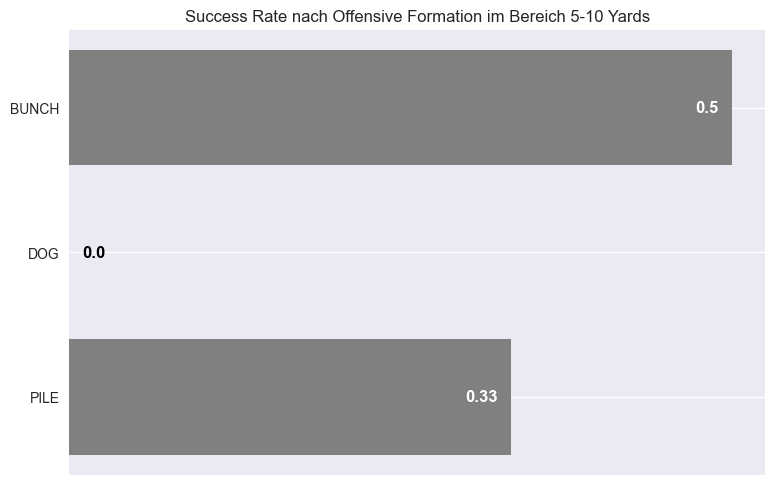

In [76]:
# fivethirtyeight-Theme anwenden
plt.style.use('seaborn-v0_8')

# Horizontales Balkendiagramm mit einer Farbe erstellen
bars = plt.barh(df["OFF FORM"], df["success_rate"], color="grey")
plt.xlabel('Success Rate')
plt.title('Success Rate nach Offensive Formation im Bereich 5-10 Yards')
# Zahlen direkt an die Balken setzen
for bar in bars:
    if bar.get_width()>0:
        plt.text(bar.get_width()-0.01, bar.get_y() + bar.get_height()/2, round(bar.get_width(), 2),
             va='center', ha='right', color='white', fontsize=12, fontweight='bold')
    else:
       plt.text(bar.get_width()+0.01, bar.get_y() + bar.get_height()/2, round(bar.get_width(), 2),
             va='center', ha='left', color='black', fontsize=12, fontweight='bold') 

# Beschriftung der x-Achse entfernen
plt.gca().axes.get_xaxis().set_visible(False)

plt.show()
plt.show()

In [18]:
import pickle

# load model
xgb_model_wp_loaded = pickle.load(open("models/wp_model.pkl", "rb"))
# xgb_model_wp_loaded = pickle.load(open("models/wp_model_simple.pkl", "rb"))

pred_spain = xgb_model_wp_loaded.predict(spain_wpa.to_numpy())

# Die Labels entsprechend deiner Definition
labels = ["wp"]

pred_spain = np.array(pred_spain)

# NumPy-Array in ein Pandas DataFrame umwandeln
probs_spain = pd.DataFrame(pred_spain, columns=labels)

# probs_spain

probs_spain = pl.from_pandas(probs_spain)

spain_wpa_raw = spain_data.hstack(probs_spain)

spain_wpa = add_wp_variables(spain_wpa_raw)

In [19]:
spain_wpa.head(5)
# .write_csv("delete_me_wp.csv",separator=";")

index,PLAY #,ODK,OFF FORM,Off Str,OFF PLAY,DN,DIST,YARD LN,RESULT,Drive Success,TARGET ROUTE,RECEIVED BY,GN/LS,Thrown By,YAC,QB,C,X/H,Y/CAT,Z,Target,Drop,B,yardline_50,game_id,play_id,drive_id,half,posteam,home_team,away_team,defteam,down,yards_to_go,yardline,yardline_50_simple,…,defteam_score,score_differential,yards_gained,first_down,half_end,game_end,helper_one,play_id_half,play_time,half_seconds_remaining,game_seconds_remaining,elapsed_share,Diff_Time_Ratio,start_posteam,receive_2h_ko,scoring_event,score_drive,Next_Score_Half,Drive_Score_Half,max_play_id,wp,tmp_posteam,home_wp,final_value,away_wp,def_wp,home_wp_after,home_wpa,wpa,home_wp_post,away_wp_post,home_team_wpa,away_team_wpa,total_home_wp,total_away_wp,total_home_wpa,total_away_wpa
u32,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i32,i32,i32,i32,i32,str,str,str,str,i32,i32,i32,i32,…,i32,i32,i32,i32,i32,i32,i32,i32,f64,f64,f64,f64,f64,str,i32,str,i32,str,i32,i32,f32,str,f64,f64,f64,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2647,"""Spain""","""Germany""","""SPREAD""","""NO""",null,"""1""","""20""","""-5""","""Complete""","""1""","""FADE""",null,"""26""","""23""",null,null,null,null,null,null,null,null,null,5,35,1,1,1,"""ESP""","""ESP""","""GER""","""GER""",1,20,-5,0,…,0,0,26,1,0,0,1,1,0.0,1200.0,2400.0,0.0,0.0,"""ESP""",0,"""Touchdown""",1,"""Touchdown""",1,41,0.490238,"""ESP""",0.490238,0.5,0.509762,0.509762,0.754435,0.264197,0.264197,0.754435,0.245565,0.264197,-0.264197,0.754435,0.245565,0.264197,-0.264197
2648,"""Spain""","""Germany""","""SPREAD""","""NO""",null,"""1""","""19""","""19""","""Complete, TD""","""1""","""FADE""",null,"""19""","""28""",null,null,null,null,null,null,null,null,null,31,35,2,1,1,"""ESP""","""ESP""","""GER""","""GER""",1,19,19,1,…,0,6,14,0,0,0,1,2,29.268293,1170.731707,2370.731707,0.012195,6.299939,"""ESP""",1,"""Touchdown""",1,"""Touchdown""",1,41,0.754435,"""ESP""",0.754435,1.0,0.245565,0.245565,0.756791,0.002356,0.002356,0.756791,0.243209,0.002356,-0.002356,1.511226,0.488774,0.266553,-0.266553
2649,"""Spain""","""Germany""","""SPREAD""","""NO""",null,"""0""","""5""","""5""","""Incomplete""","""0""","""SHALLOW""",null,"""0""","""5""",null,null,null,null,null,null,null,null,null,45,35,3,1,1,"""ESP""","""ESP""","""GER""","""GER""",0,5,5,1,…,0,6,0,0,0,0,1,3,29.268293,1141.463415,2341.463415,0.02439,6.614872,"""ESP""",1,"""Touchdown""",2,"""Opp_Touchdown""",2,41,0.756791,"""ESP""",0.756791,1.0,0.243209,0.243209,0.761198,0.004407,0.004407,0.761198,0.238802,0.004407,-0.004407,2.272424,0.727576,0.27096,-0.27096
2650,"""Germany""","""Spain""","""DOG""","""S Drop""","""Mills""","""1""","""20""","""-5""","""Incomplete""","""1""","""CURL""",null,"""0""","""7""","""THIELE""","""RIESS""","""Thiele""","""Pietryga""","""de Gavarelli""","""Stevens""","""Riess""",null,null,5,35,4,2,1,"""GER""","""ESP""","""GER""","""ESP""",1,20,-5,0,…,6,-6,0,0,0,0,1,4,29.268293,1112.195122,2312.195122,0.036585,-6.945548,"""ESP""",1,"""Touchdown""",2,"""Touchdown""",2,41,0.238802,"""GER""",0.761198,1.0,0.238802,0.761198,0.767609,0.00641,-0.00641,0.767609,0.232391,0.00641,-0.00641,3.040033,0.959967,0.277371,-0.277371
2651,"""Germany""","""Spain""","""DOG""","""S Drop""","""Dagger""","""2""","""20""","""-5""","""Complete""","""1""","""POCO""","""PIETRYGA""","""24""","""17""","""THIELE""","""PIETRYGA""","""Thiele""","""Pietryga""","""de Gavarelli""","""Stevens""","""Riess""",null,null,5,35,5,2,1,"""GER""","""ESP""","""GER""","""ESP""",2,20,-5,0,…,6,-6,24,1,0,0,1,5,29.268293,1082.926829,2282.926829,0.04878,-7.292755,"""ESP""",1,"""Touchdown""",2,"""Touchdown""",2,41,0.232391,"""GER""",0.767609,1.0,0.232391,0.767609,0.783855,0.016247,-0.016247,0.783855,0.216145,0.016247,-0.016247,3.823888,1.176112,0.293617,-0.293617


Text(0.13, 0.12, 'Graph: @ChristianLohr9')

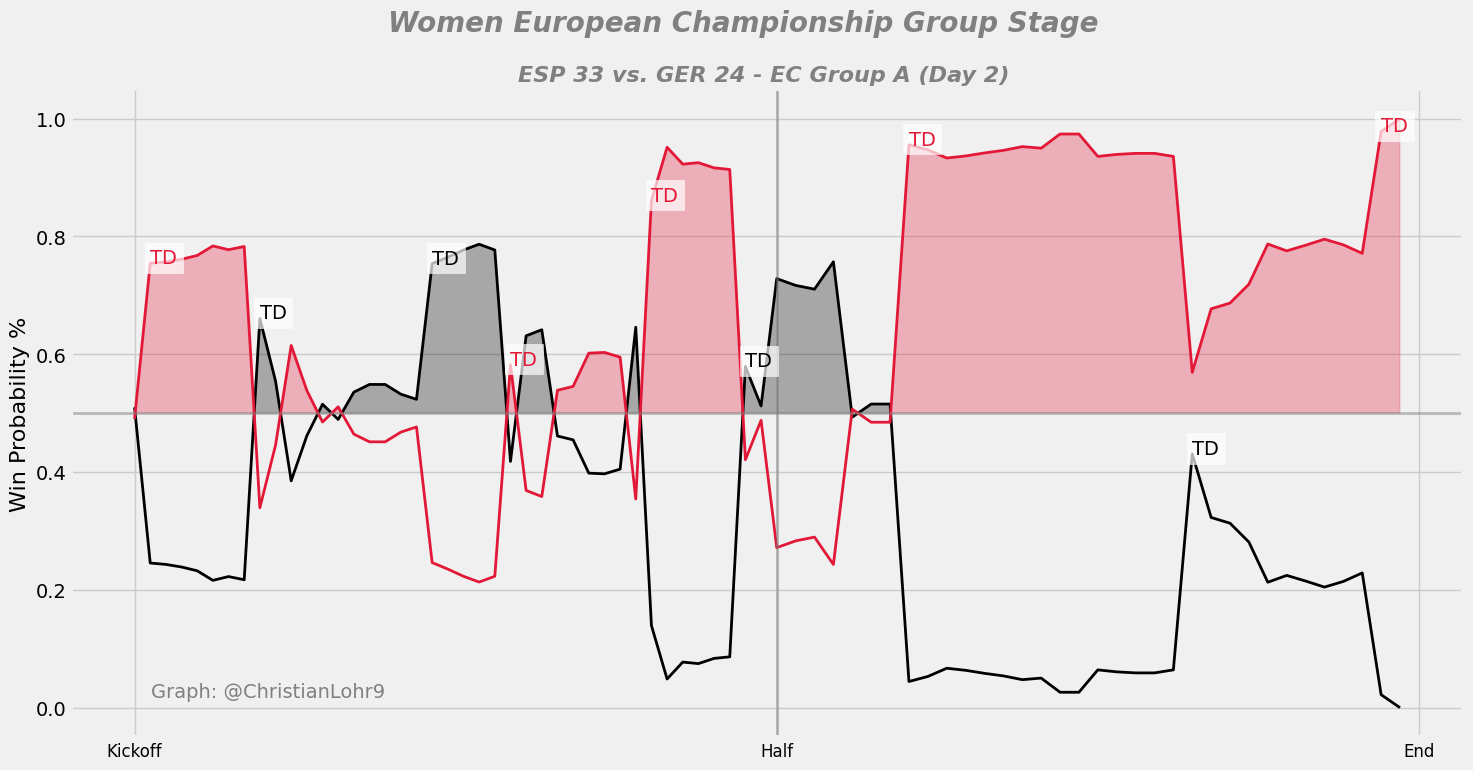

In [20]:
spain_wpa = (
    spain_wpa
    .with_columns(
        plt_label_home = 
        pl.when((pl.col("scoring_play_team") == pl.col("home_team")) & (pl.col("scoring_play") == 1) & (pl.col("scoring_event") == "Touchdown"))
        .then(pl.lit("TD"))
        .when((pl.col("scoring_play_team") == pl.col("home_team")) & (pl.col("scoring_play") == 1) & (pl.col("scoring_event") == "Safety"))
        .then(pl.col("scoring_event"))
        .when((pl.col("scoring_play_team") == pl.col("home_team")) & (pl.col("scoring_play") == 1) & (pl.col("scoring_event") == "Extra_Point"))
        .then(pl.lit(None))
        .when((pl.col("scoring_play_team") == pl.col("home_team")) & (pl.col("scoring_play") == 1) & (pl.col("scoring_event") == "Opp_Touchdown"))
        .then(pl.lit(None))
        .otherwise(pl.lit(None)),
        plt_label_away = 
        pl.when((pl.col("scoring_play_team") == pl.col("away_team")) & (pl.col("scoring_play") == 1) & (pl.col("scoring_event") == "Touchdown"))
        .then(pl.lit("TD"))
        .when((pl.col("scoring_play_team") == pl.col("away_team")) & (pl.col("scoring_play") == 1) & (pl.col("scoring_event") == "Safety"))
        .then(pl.col("scoring_event"))
        .when((pl.col("scoring_play_team") == pl.col("away_team")) & (pl.col("scoring_play") == 1) & (pl.col("scoring_event") == "Extra_Point"))
        .then(pl.lit(None))
        .when((pl.col("scoring_play_team") == pl.col("away_team")) & (pl.col("scoring_play") == 1) & (pl.col("scoring_event") == "Opp_Touchdown"))
        .then(pl.lit(None))
        .otherwise(pl.lit(None)))
)
#Set style
plt.style.use('fivethirtyeight')

#Create a figure
fig, ax = plt.subplots(figsize=(16,8))

#Generate lineplots
sns.lineplot(data=spain_wpa, x='game_seconds_remaining', y='away_wp', 
             color='black',linewidth=2)

sns.lineplot(data=spain_wpa, x='game_seconds_remaining', y='home_wp', 
             color='#E31837',linewidth=2)

for i, txt in enumerate(spain_wpa["plt_label_away"]):
    ax.text(spain_wpa["game_seconds_remaining"][i], spain_wpa["away_wp"][i], txt, color="black").set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))
for i, txt in enumerate(spain_wpa["plt_label_home"]):
    ax.text(spain_wpa["game_seconds_remaining"][i], spain_wpa["home_wp"][i], txt, color="#E31837").set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

#Generate fills for the favored team at any given time

ax.fill_between(spain_wpa['game_seconds_remaining'], 0.5, spain_wpa['away_wp'], 
                where=spain_wpa['away_wp']>.5, color = 'black',alpha=0.3, interpolate=True)

ax.fill_between(spain_wpa['game_seconds_remaining'], 0.5, spain_wpa['home_wp'], 
                where=spain_wpa['home_wp']>.5, color = '#E31837',alpha=0.3, interpolate=True)

#Labels
plt.ylabel('Win Probability %', fontsize=16)
plt.xlabel('', fontsize=16)

#Divider lines for aesthetics
plt.axvline(x=1200, color='#808080', alpha=0.5, linewidth = 2)
plt.axhline(y=.50, color='#808080', alpha=0.5, linewidth = 2)

#Format and rename xticks
ax.set_xticks(np.arange(0, 2401,1200))

plt.gca().invert_xaxis()
x_ticks_labels = ['End','Half','Kickoff']
ax.set_xticklabels(x_ticks_labels, fontsize=12)

#Titles

plt.suptitle('Women European Championship Group Stage', 
             fontsize=20, style='italic',weight='bold', color = "#808080")

plt.title('ESP 33 vs. GER 24 - EC Group A (Day 2) ', fontsize=16, 
          style='italic', weight='semibold', color = "#808080")

#Citations
plt.figtext(0.13,0.12,'Graph: @ChristianLohr9', color = "#808080")

#Save figure if you wish
#plt.savefig('winprobchart.png', dpi=300)